In [1]:
from sklearn.metrics import accuracy_score

In [2]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate
from keras.layers import LSTM
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences

//anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
from functools import reduce
import tarfile
import numpy as np
import re


def tokenize(sent):
    token = []
    for x in re.split('(\W+)?', sent):
        if x.strip():
            token.append(x.strip())
    return token

def parse_stories(lines,only_supporting=False):
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            q = tokenize(q)
            substory = None
            if only_supporting:
                # Only select the related substory
                supporting = map(int, supporting.split())
                substory = [story[i - 1] for i in supporting]
            else:
                # Provide all the substories
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            sent = tokenize(line)
            story.append(sent)
    return data


def get_stories(file,only_supporting=False):
    data = parse_stories(file.readlines(),only_supporting)
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    
    temp_data = []
    for story, q, answer in data:
        temp_data.append((flatten(story), q, answer))
    return temp_data


def vectorize_stories(data):
    inputs, queries, answers = [], [], []
    for story, query, answer in data:
        inputs.append([word_idx[w] for w in story])
        queries.append([word_idx[w] for w in query])
        answers.append(word_idx[answer])
    return (pad_sequences(inputs, maxlen=story_maxlen),
            pad_sequences(queries, maxlen=query_maxlen),
            np.array(answers))

# Download the dataset
try:
    path = get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
except:
    print('Error downloading dataset, please download it manually:\n'
          '$ wget http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2.tar.gz\n'
          '$ mv tasks_1-20_v1-2.tar.gz ~/.keras/datasets/babi-tasks-v1-2.tar.gz')
    raise


task = 'tasks_1-20_v1-2/en/qa5_three-arg-relations_{}.txt'

with tarfile.open(path) as tar:
    train_stories = get_stories(tar.extractfile(task.format('train')),only_supporting=True)
    test_stories = get_stories(tar.extractfile(task.format('test')),only_supporting=True)

    
vocab = set()
for story, q, answer in train_stories + test_stories:
    vocab |= set(story + q + [answer])
vocab = sorted(vocab)


vocab_size = len(vocab) + 1

story_maxlen = max(map(len, (x for x, _, _ in train_stories + test_stories)))
query_maxlen = max(map(len, (x for _, x, _ in train_stories + test_stories)))

word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
inputs_train, queries_train, answers_train = vectorize_stories(train_stories)
inputs_test, queries_test, answers_test = vectorize_stories(test_stories)

print('vocab = {}'.format(vocab))
print('x.shape = {}'.format(inputs_train.shape))
print('xq.shape = {}'.format(queries_train.shape))
print('y.shape = {}'.format(answers_train.shape))
print('story_maxlen, query_maxlen = {}, {}'.format(story_maxlen, query_maxlen))

//anaconda/lib/python3.5/re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


vocab = ['.', '?', 'Bill', 'Fred', 'Jeff', 'Mary', 'What', 'Who', 'apple', 'did', 'football', 'gave', 'give', 'handed', 'milk', 'passed', 'received', 'the', 'to']
x.shape = (1000, 7)
xq.shape = (1000, 8)
y.shape = (1000,)
story_maxlen, query_maxlen = 7, 8


In [7]:

input_sequence = Input((story_maxlen,))
question = Input((query_maxlen,))

input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=64))
input_encoder_m.add(Dropout(0.3))

input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=query_maxlen))
input_encoder_c.add(Dropout(0.3))

question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=query_maxlen))
question_encoder.add(Dropout(0.3))


input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)


match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)


response = add([match, input_encoded_c])
response = Permute((2, 1))(response)


answer = concatenate([response, question_encoded])

answer = LSTM(32)(answer)


answer = Dropout(0.3)(answer)
answer = Dense(vocab_size)(answer)

answer = Activation('softmax')(answer)


model = Model([input_sequence, question], answer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train
model.fit([inputs_train, queries_train], answers_train,
          batch_size=32,
          epochs=100,
          validation_data=([inputs_test, queries_test], answers_test))

Train on 1000 samples, validate on 1000 samples
Epoch 1/100
1000/1000 [==============================] - 1s 1ms/step - loss: 2.8547 - acc: 0.1570 - val_loss: 2.5413 - val_acc: 0.1880
Epoch 2/100
1000/1000 [==============================] - 0s 493us/step - loss: 2.1521 - acc: 0.1970 - val_loss: 1.6843 - val_acc: 0.2890
Epoch 3/100
1000/1000 [==============================] - 0s 478us/step - loss: 1.6049 - acc: 0.2770 - val_loss: 1.3796 - val_acc: 0.3330
Epoch 4/100
1000/1000 [==============================] - 0s 493us/step - loss: 1.4495 - acc: 0.2960 - val_loss: 1.3361 - val_acc: 0.3330
Epoch 5/100
1000/1000 [==============================] - 0s 496us/step - loss: 1.4282 - acc: 0.2930 - val_loss: 1.3239 - val_acc: 0.3520
Epoch 6/100
1000/1000 [==============================] - 0s 478us/step - loss: 1.3945 - acc: 0.3100 - val_loss: 1.3193 - val_acc: 0.3060
Epoch 7/100
1000/1000 [==============================] - 1s 661us/step - loss: 1.3774 - acc: 0.2860 - val_loss: 1.3095 - val_acc: 0.

In [ ]:
idxToWord = {}
for key,value in word_idx.items():
    idxToWord[value] = key

In [7]:
predicted_values = model.predict([inputs_test, queries_test])
predicted=[]
true=[]
for i in range(predicted_values.shape[0]):
    predicted.append(idxToWord[np.argmax(predicted_values[i])])
    true.append(idxToWord[answers_test[i]])

In [8]:
from pandas_ml import ConfusionMatrix

In [9]:
import matplotlib.pyplot as plt

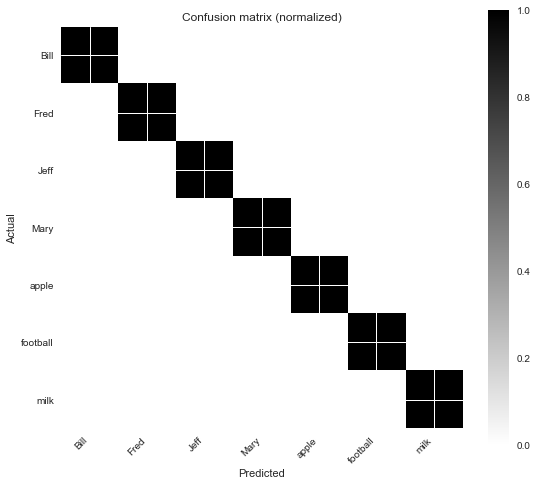

In [10]:
cm = ConfusionMatrix(predicted,true)
cm.plot(normalized=True)
plt.show()

In [11]:
#val_loss: 4.9372 - val_acc: 0.5340 EPOCH 500 - NonSupport

In [12]:
#val_loss: 2.4631 - val_acc: 0.5230 EPOCH 100 - NonSupport

In [13]:
#val_loss: 1.2375 - val_acc: 0.4900 EPOCH 40 - NonSupport

In [14]:
#val_loss: 0.5266 - val_acc: 0.8010 EPOCH 40 - Support

In [15]:
#val_loss: 0.0029 - val_acc: 1.0000 EPOCH 100 - Support

In [16]:
#val_loss: 1.9073e-06 - val_acc: 1.0000 EPOCH 500 - Support